In [61]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import math

import time
import wavio

import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg

from sklearn.linear_model import Lasso

env: CUDA_VISIBLE_DEVICES=0


In [62]:
wave = wavio.read("TestingR.wav")
WAVE_RATE = wave.rate
WAVE_LEN = wave.data.shape[0]
WAVE_RES = wave.sampwidth
nc = wave.data.shape[1]
y0 = wave.data

print("Sampling Rate: ", WAVE_RATE)
print("Num Samples: ", WAVE_LEN)
print("Clip Length: ", round(WAVE_LEN/(1.0*WAVE_RATE), 2))
print("Bits/Sample: ", 8*WAVE_RES)
print("Num Channels: ", nc)

Sampling Rate:  8192
Num Samples:  16384
Clip Length:  2.0
Bits/Sample:  16
Num Channels:  1


In [63]:
compressed = True
compressed_noisy = False

if compressed:
    num_measurements = 2000
else:
    num_measurements = WAVE_LEN

In [64]:
#ugly solution for maintaining wave's original image stats for normalization/renormalization 
#normalization maps wave's range: [a,b] --> [-1,1], renormalization reverses this
def get_stats(x):
    chans = x.shape[1]
    
    a = np.zeros((chans))
    b = np.zeros((chans))
    mu = np.zeros((chans))
    sigma = np.zeros((chans))
    
    for c in range(chans):
        a[c] = np.min(x[:,c])
        b[c] = np.max(x[:,c])
        mu[c] = (a[c]+b[c])/2.0
        sigma[c] = (b[c]-a[c])/2.0
    
    return [mu, sigma]

MU = get_stats(y0)[0]
SIGMA = get_stats(y0)[1]

def normalise(x, mean, std):
    normalised = np.zeros((x.shape))
    chans = x.shape[1]
    
    for c in range(chans):
        normalised[:,c] = (x[:,c] - mean[c])/std[c]
        
    return normalised

def renormalise(x, mean, std):
    normalised = np.zeros((x.shape))
    chans = x.data.shape[1]
    
    for c in range(chans):
        normalised[:,c] = x[:,c] * std[c] + mean[c]
        
    return normalised

print("Means: ", MU)
print("STD: ", SIGMA)

Means:  [-0.5]
STD:  [32767.5]


In [65]:
if compressed:
    if not compressed_noisy:
        kept_samples = random.sample(range(0, WAVE_LEN*nc), num_measurements) #randomly select num_measurements samples to keep
        A = spfft.idct(np.identity(WAVE_LEN*nc), norm='ortho', axis=0)[kept_samples,:] #grab rows corresponding to index of randomly
        measurements = y0[kept_samples,:]
    else:
        samp_matrix = (1 / math.sqrt(1.0 * num_measurements)) * np.random.randn(num_measurements, WAVE_LEN * nc)
        A = np.matmul(samp_matrix, spfft.idct(np.identity(WAVE_LEN*nc), norm = 'ortho', axis=0))
        measurements = np.matmul(samp_matrix, y0)
else:
    A = spfft.idct(np.identity(WAVE_LEN*nc), norm='ortho', axis=0)
    measurements = y0
    
print(A.shape)
print(measurements.shape)

(2000, 16384)
(2000, 1)


In [66]:
lasso = Lasso(alpha = 0.001)
lasso.fit(A, measurements)

x_hat = np.array(lasso.coef_).reshape(WAVE_LEN*nc)
x_hat = spfft.idct(x_hat, norm = 'ortho', axis=0)
x_hat = x_hat.reshape(-1,1)

/home/sravula/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [67]:
print(y0.shape)
print(x_hat.shape)

(16384, 1)
(16384, 1)


In [68]:
mse = np.mean((normalise(y0, MU, SIGMA).reshape((1, -1)) - normalise(x_hat, MU, SIGMA).reshape((1, -1)))**2)
print(mse)

0.0027631417680399235


In [69]:
#wavio.write("Audio_recon/Lasso_" + str(num_measurements) + "_testR.wav", x_hat, WAVE_RATE, sampwidth=WAVE_RES)

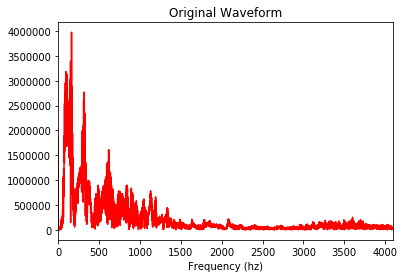

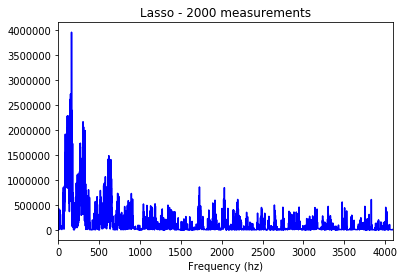

In [70]:
spectrum =np.fft.fft(y0[:,0])
spectrum = abs(spectrum[0:round(len(spectrum)/2)]) # Just first half of the spectrum, as the second is the negative copy

plt.figure()
plt.plot(spectrum, 'r')
plt.xlabel('Frequency (hz)')
plt.title('Original Waveform')
plt.xlim(0,WAVE_RATE/2)
plt.show()

plt.figure()
plt.plot(abs(np.fft.fft(x_hat[:,0])[0:round(len(spectrum)/2)]), 'b')
plt.xlabel('Frequency (hz)')
plt.title("Lasso - " + str(num_measurements) + " measurements")
plt.xlim(0, WAVE_RATE/2)
plt.savefig("Freq_recon/Lasso_" + str(num_measurements) + "_testR.jpg")
plt.show()